In [2]:
from glob import glob
from script_converter import get_transformation_matrix
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import pydicom
import numpy as np
from rt_utils.image_helper import apply_transformation_to_3d_points

## T2 Conversion

Dimensions: 320 * 320


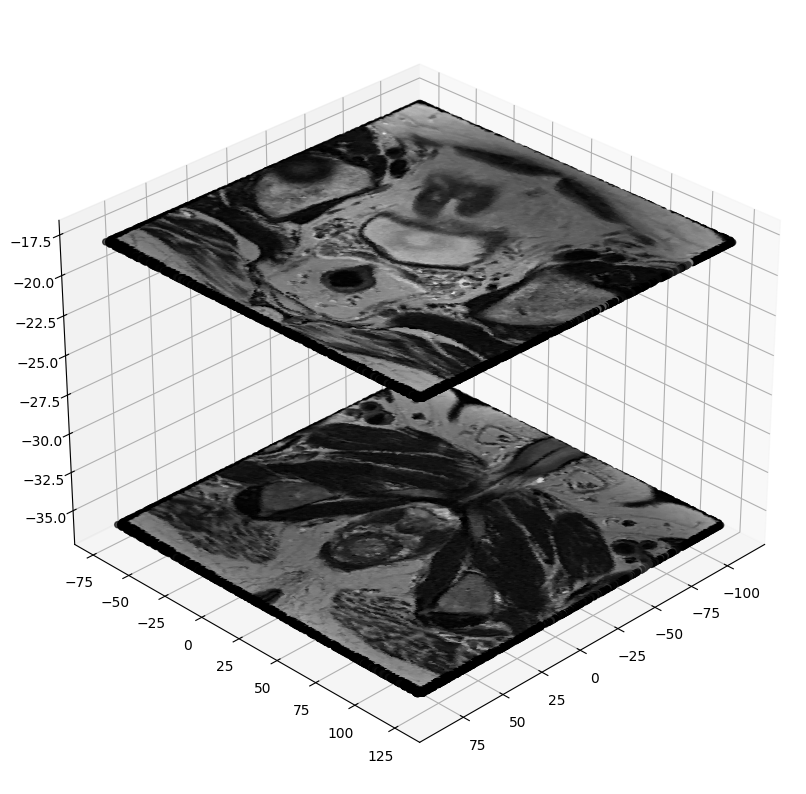

In [4]:
t2_mat = get_transformation_matrix('data/t2/')
new_t2_mat = np.array(t2_mat)
t2_img1_dcm = pydicom.dcmread('data/t2/IM-6392-0001.dcm')
t2_img1 = t2_img1_dcm.pixel_array

t2_img20_dcm = pydicom.dcmread('data/t2/IM-6392-0020.dcm')
t2_img20 = t2_img20_dcm.pixel_array

t2_h, t2_w = t2_img1_dcm.pixel_array.shape     # 320*320

print("Dimensions: " + str(t2_h) + " * " + str(t2_w))

t2_ys, t2_xs = np.where(np.ones((t2_h, t2_w)))
t2_coords = np.concatenate((t2_ys.reshape(-1, 1), t2_xs.reshape(-1, 1)), axis=1)

t2_extended_coords_list = []
t2_patient_coords_list = []

for i in range(20):
    t2_extended_coords = np.concatenate((t2_coords, np.ones((t2_h * t2_w, 1)) * i), axis=1)
    t2_extended_coords_list.append(t2_extended_coords)

for i in range(20):
    t2_patient_coords = apply_transformation_to_3d_points(t2_extended_coords_list[i], new_t2_mat)
    t2_patient_coords_list.append(t2_patient_coords)

t2_indice = np.random.choice(len(t2_ys), 100000)

t2_img1 = ((t2_img1/t2_img1.max())).flatten()

colors = [[c, c, c] for c in t2_img1[t2_indice]]

fig = plt.figure(figsize=(10, 20))
ax = fig.add_subplot(projection='3d')

ax.scatter(t2_patient_coords_list[0][t2_indice,0], t2_patient_coords_list[0][t2_indice,1], t2_patient_coords_list[0][t2_indice,2], color=colors)

t2_img20 = ((t2_img20/t2_img20.max())).flatten()
colors = [[c, c, c] for c in t2_img20[t2_indice]]
ax.scatter(t2_patient_coords_list[-1][t2_indice,0], t2_patient_coords_list[-1][t2_indice,1], t2_patient_coords_list[-1][t2_indice,2], color=colors)

ax.view_init(elev=30, azim=45)

## Ktrans Conversion

## Visualize